In [8]:
# ライブラリの読み込み
import os
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
print(torch.cuda.is_available())
device = torch.device("cuda:0")
print(device)

import matplotlib.pyplot as plt
%matplotlib inline

True
cuda:0


In [21]:
#データセットを学習データと検証データに分割
def make_filepath_list():
    train_file_list = []
    valid_file_list = []
    
    for top_dir in os.listdir('./train/'):
        file_dir = os.path.join('./train/', top_dir) #ディレクトリ名格納
        file_list = os.listdir(file_dir) #各データ名格納
        
        # 各呼吸音画像ごとに8割を学習データ、2割を検証データとする
        num_data = len(file_list)
        num_split = int(num_data * 0.9)
#         print(f'{file_dir} : {num_data}')
#         #print(num_split)
        
        train_file_list += [os.path.join('./train', top_dir, file).replace('\\', '/') for file in file_list[:num_split]]
        valid_file_list += [os.path.join('./train', top_dir, file).replace('\\', '/') for file in file_list[num_split:]]
    
    return train_file_list, valid_file_list

# 画像データへのファイルパスを格納したリストを取得する
train_file_list, valid_file_list = make_filepath_list()

# print('学習データ数 : ', len(train_file_list[])
# # 先頭3件だけ表示
# print(train_file_list)

# print('検証データ数 : ', len(valid_file_list[:3]))
# # 先頭3件だけ表示
# print(valid_file_list)

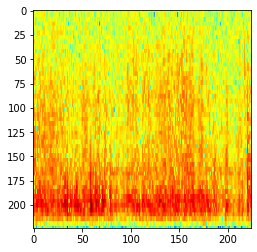

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


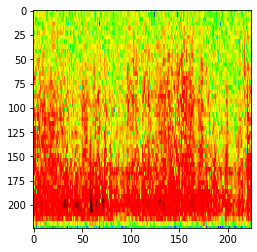

In [22]:
class ImageTransform(object):
    """
    入力画像の前処理クラス
    画像のサイズをリサイズする
    
    Attributes
    ----------
    resize: int
        リサイズ先の画像の大きさ
    mean: (R, G, B)
        各色チャンネルの平均値
    std: (R, G, B)
        各色チャンネルの標準偏差
    """
    def __init__(self, resize, mean, std):
        self.data_trasnform = {
            'train': transforms.Compose([
                # データオーグメンテーション
                #ransforms.RandomHorizontalFlip(),
                # 画像をresize×resizeの大きさに統一する
                transforms.Resize((resize, resize)),
                # Tensor型に変換する
                transforms.ToTensor(),
                # 色情報の標準化をする
                transforms.Normalize(mean, std)
            ]),
            'valid': transforms.Compose([
                # 画像をresize×resizeの大きさに統一する
                transforms.Resize((resize, resize)),
                # Tensor型に変換する
                transforms.ToTensor(),
                # 色情報の標準化をする
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_trasnform[phase](img)

# 動作確認
img = Image.open('./train/crackle/176_2b3_Lr_mc_AKGC417L_5.png')

# リサイズ先の画像サイズ
resize = 224

# 今回は簡易的に(0.5, 0.5, 0.5)で標準化
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transform = ImageTransform(resize, mean, std)
img_transformed = transform(img, 'train')

plt.imshow(img)
plt.show()

plt.imshow(img_transformed.numpy().transpose((1, 2, 0)))
plt.show()

In [23]:
import glob 

class RespiratoryDataset(data.Dataset):
    """
    呼吸音のDatasetクラス。
    PyTorchのDatasetクラスを継承させる。
    
    Attrbutes
    ---------
    file_list: list
        画像のファイルパスを格納したリスト
    classes: list
        各呼吸音のラベル名
    transform: object
        前処理クラスのインスタンス
    phase: 'train' or 'valid'
        学習か検証化を設定
    """
    def __init__(self, file_list, classes, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.classes = classes
        self.phase = phase
    
    def __len__(self):
        """
        画像の枚数を返す
        """
        return len(self.file_list)
    
    def __getitem__(self, index):
        """
        前処理した画像データのTensor形式のデータとラベルを取得
        """
         # 指定したindexの画像を読み込む
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        # 画像の前処理を実施
        img_transformed = self.transform(img, self.phase)
        
        # 画像ラベルをファイル名から抜き出す
        label = self.file_list[index].split('/')[-2]
        #print(label)
        # ラベル名を数値に変換
        label_int = self.classes.index(label)
        #print(label)
        return img_transformed, label_int

# 動作確認
# クラス名
#respiratory_classes = [path.split('/')[-2] for path in glob.glob('./dataset/*/')]
respiratory_classes = ['crackle','wheeze','crackle_wheeze','normal']
print(respiratory_classes)
# リサイズ先の画像サイズ
resize = 224

# 今回は簡易的に(0.5, 0.5, 0.5)で標準化
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# Datasetの作成
train_dataset = RespiratoryDataset(
    file_list=train_file_list, classes=respiratory_classes,
    transform=ImageTransform(resize, mean, std),
    phase='train'
)

valid_dataset = RespiratoryDataset(
    file_list=valid_file_list, classes=respiratory_classes,
    transform=ImageTransform(resize, mean, std),
    phase='valid'
)

index = 2500
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

['crackle', 'wheeze', 'crackle_wheeze', 'normal']
torch.Size([3, 224, 224])
2


In [24]:
# バッチサイズの指定
batch_size = 64

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=32, shuffle=False)

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'val': valid_dataloader
}

In [25]:
import torchvision.models as models

class vgg_model(nn.Module):

    def __init__(self):
        super(vgg_model, self).__init__()

        self.conv01 = nn.Conv2d(3, 16, 3)
        self.conv02 = nn.Conv2d(16, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv03 = nn.Conv2d(16, 24, 3)
        self.conv04 = nn.Conv2d(24, 24, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv05 = nn.Conv2d(24, 32, 3)
        self.conv06 = nn.Conv2d(32, 32, 3)
        self.conv07 = nn.Conv2d(32, 32, 3)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv08 = nn.Conv2d(32, 40, 3)
        self.conv09 = nn.Conv2d(40, 40, 3)
        self.conv10 = nn.Conv2d(40, 40, 3)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv11 = nn.Conv2d(40, 48, 3)
        self.conv12 = nn.Conv2d(48, 48, 3)
        self.conv13 = nn.Conv2d(48, 48, 3)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.avepool1 = nn.AdaptiveAvgPool2d((7, 7))

        self.fc1 = nn.Linear(48 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 4)

        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)



    def forward(self, x):
        x = F.relu(self.conv01(x))
        x = F.relu(self.conv02(x))
        x = self.pool1(x)

        x = F.relu(self.conv03(x))
        x = F.relu(self.conv04(x))
        x = self.pool2(x)

        x = F.relu(self.conv05(x))
        x = F.relu(self.conv06(x))
        x = F.relu(self.conv07(x))
        x = self.pool3(x)

        x = F.relu(self.conv08(x))
        x = F.relu(self.conv09(x))
        x = F.relu(self.conv10(x))
        x = self.pool4(x)

        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.pool5(x)

        x = self.avepool1(x)

        # 行列をベクトルに変換
        x = x.view(-1, 48 * 7 * 7)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

# # 学習済みモデルの取得
# model = models.vgg16_bn(pretrained=False)
 
# # 全結合層の変更(最終層の出力を2にする)
# model.classifier = nn.Sequential(
#     nn.Linear(512 * 7 * 7, 4096),
#     nn.ReLU(True),
#     nn.Dropout(),
#     nn.Linear(4096, 4096),
#     nn.ReLU(True),
#     nn.Dropout(),
#     nn.Linear(4096, 4),
# )
 
# # GPUを使う
# #device = torch.device('cuda')
net = vgg_model().to(device)
print(net)

vgg_model(
  (conv01): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv02): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv03): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv04): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv05): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv06): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv07): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv08): Conv2d(32, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv09): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv11): Conv2d(40, 48,

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [27]:
# エポック数
num_epochs = 30

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    
    for phase in ['train', 'val']:
        
        if phase == 'train':
            # モデルを訓練モードに設定
            net.train()
        else:
            # モデルを推論モードに設定
            net.eval()
        
        # 損失和
        epoch_loss = 0.0
        # 正解数
        epoch_corrects = 0
        
        # DataLoaderからデータをバッチごとに取り出す
        for inputs, labels in dataloaders_dict[phase]:
            inputs= inputs.to(device)
            labels = labels.to(device)
            # optimizerの初期化
            optimizer.zero_grad()
            
            # 学習時のみ勾配を計算させる設定にする
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                #print(outputs)
                # 損失を計算
                loss = criterion(outputs, labels)
                
                # ラベルを予測
                _, preds = torch.max(outputs, 1)
            
                
                # 訓練時はバックプロパゲーション
                if phase == 'train':
                    # 逆伝搬の計算
                    loss.backward()
                    # パラメータの更新
                    optimizer.step()
                
                # イテレーション結果の計算
                # lossの合計を更新
                # PyTorchの仕様上各バッチ内での平均のlossが計算される。
                # データ数を掛けることで平均から合計に変換をしている。
                # 損失和は「全データの損失/データ数」で計算されるため、
                # 平均のままだと損失和を求めることができないため。
                epoch_loss += loss.item() * inputs.size(0)
                # 正解数の合計を更新
                epoch_corrects += torch.sum(preds == labels.data)
                

        # epochごとのlossと正解率を表示
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 1/30
-------------
train Loss: 1.3169 Acc: 0.5243
val Loss: 1.2620 Acc: 0.5275
Epoch 2/30
-------------
train Loss: 1.2277 Acc: 0.5280
val Loss: 1.2004 Acc: 0.5275
Epoch 3/30
-------------
train Loss: 1.1834 Acc: 0.5280
val Loss: 1.1707 Acc: 0.5275
Epoch 4/30
-------------


KeyboardInterrupt: 